Install Modules

In [23]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install pydot
%pip install graphviz
%pip install tensorflow
%pip install keras

In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img  # Use tf.keras.preprocessing.image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

Load the Dataset

In [25]:
!unzip UTKFace.zip

Archive:  UTKFace.zip
   creating: UTKFace/
  inflating: UTKFace/.DS_Store       
  inflating: UTKFace/100_1_0_20170119212053665.jpg  
  inflating: UTKFace/10_0_0_20170116201102149.jpg  
  inflating: UTKFace/10_0_0_20170120220628194.jpg  
  inflating: UTKFace/10_0_1_20170116225209209.jpg  
  inflating: UTKFace/10_1_1_20170116225209209.jpg  
  inflating: UTKFace/10_1_3_20170119150820222.jpg  
  inflating: UTKFace/110_1_0_20170120134701015.jpg  
  inflating: UTKFace/111_1_0_20170120134646399.jpg  
  inflating: UTKFace/115_1_0_20170120134725990.jpg  
  inflating: UTKFace/115_1_0_20170120134725991.jpg  
  inflating: UTKFace/116_1_0_20170120134921760.jpg  
  inflating: UTKFace/116_1_3_20170120134744096.jpg  
  inflating: UTKFace/11_1_0_20170117133441179.jpg  
  inflating: UTKFace/13_0_3_20170119153840721.jpg  
  inflating: UTKFace/13_1_0_20170120133325603.jpg  
  inflating: UTKFace/14_0_0_20170116204045849.jpg  
  inflating: UTKFace/14_0_0_20170116211955846.jpg  
  inflating: UTKFace/14_0_0

In [26]:
BASE_DIR = '/content/UTKFace'

In [27]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    if filename.startswith('.'):  # Check if filename starts with a dot (hidden files)
        continue  # Skip hidden files like .DS_Store
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/3253 [00:00<?, ?it/s]

In [28]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/28_1_1_20170116223115624.jpg,28,1
1,/content/UTKFace/85_1_0_20170120230302610.jpg,85,1
2,/content/UTKFace/45_0_0_20170119200455965.jpg,45,0
3,/content/UTKFace/45_0_3_20170119202030421.jpg,45,0
4,/content/UTKFace/26_1_3_20170119193123985.jpg,26,1


In [29]:
gender_dict = {0:'Male', 1:'Female'}

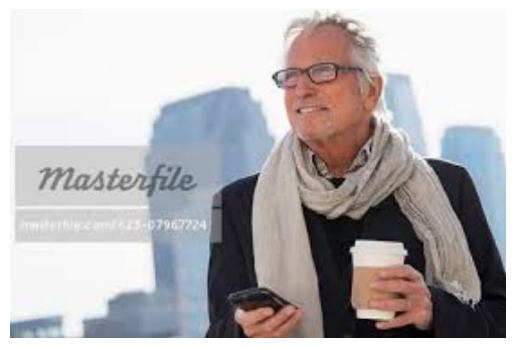

In [30]:
from PIL import Image
img = Image.open(df['image'][10])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

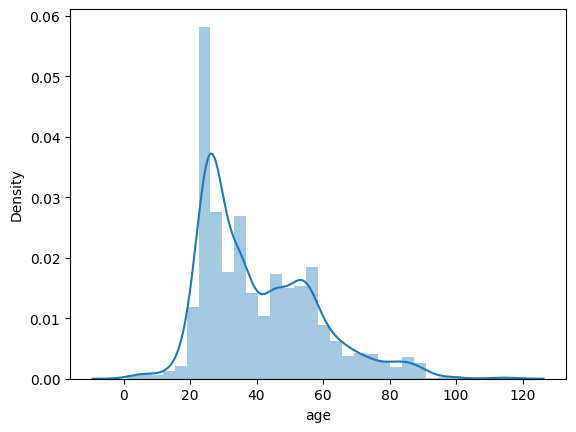

In [31]:
sns.distplot(df['age'])

Text(0.5, 1.0, 'Distribution of Gender')

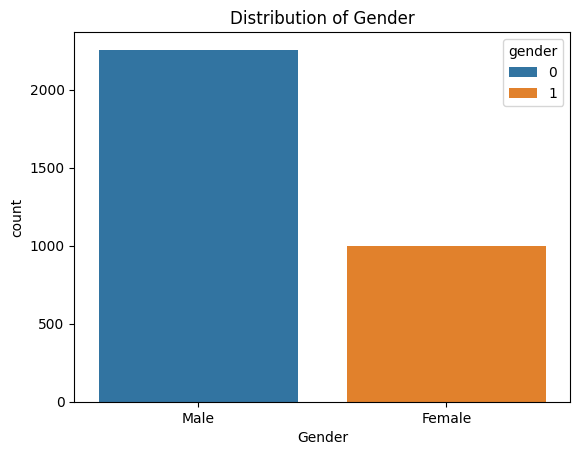

In [32]:
sns.countplot(x='gender', data=df, hue='gender')
plt.xlabel("Gender")
plt.xticks([0, 1], labels=["Male", "Female"])
plt.title("Distribution of Gender")

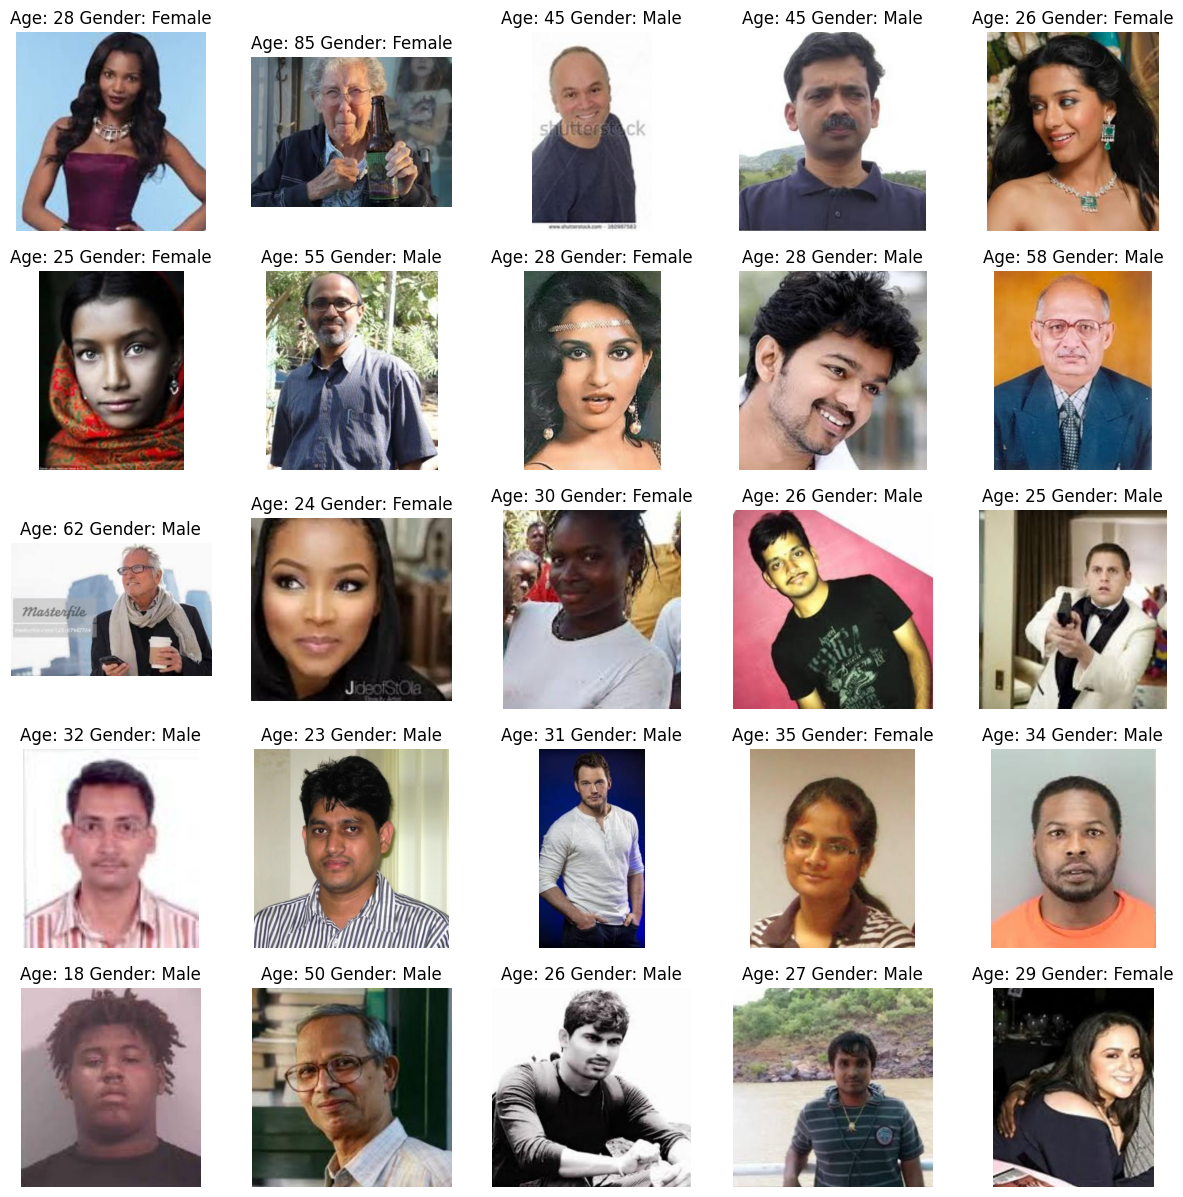

In [33]:
plt.figure(figsize=(15, 15))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [34]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        # Load image using PIL and convert to grayscale
        img = Image.open(image).convert('L')
        # Use Image.Resampling.LANCZOS instead of Image.ANTIALIAS
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [35]:
X = extract_features(df['image'])

  0%|          | 0/3252 [00:00<?, ?it/s]

In [36]:
X.shape

(3252, 128, 128, 1)

In [37]:
X = X/255.0

In [38]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [39]:
input_shape = (128, 128, 1)

Model Creation

In [51]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(117, activation='softmax', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(
    loss={
        'gender_out': 'binary_crossentropy',
        'age_out': 'sparse_categorical_crossentropy'
    },
    optimizer='adam',
    metrics={
        'gender_out': 'accuracy',
        'age_out': 'accuracy'
    }
)

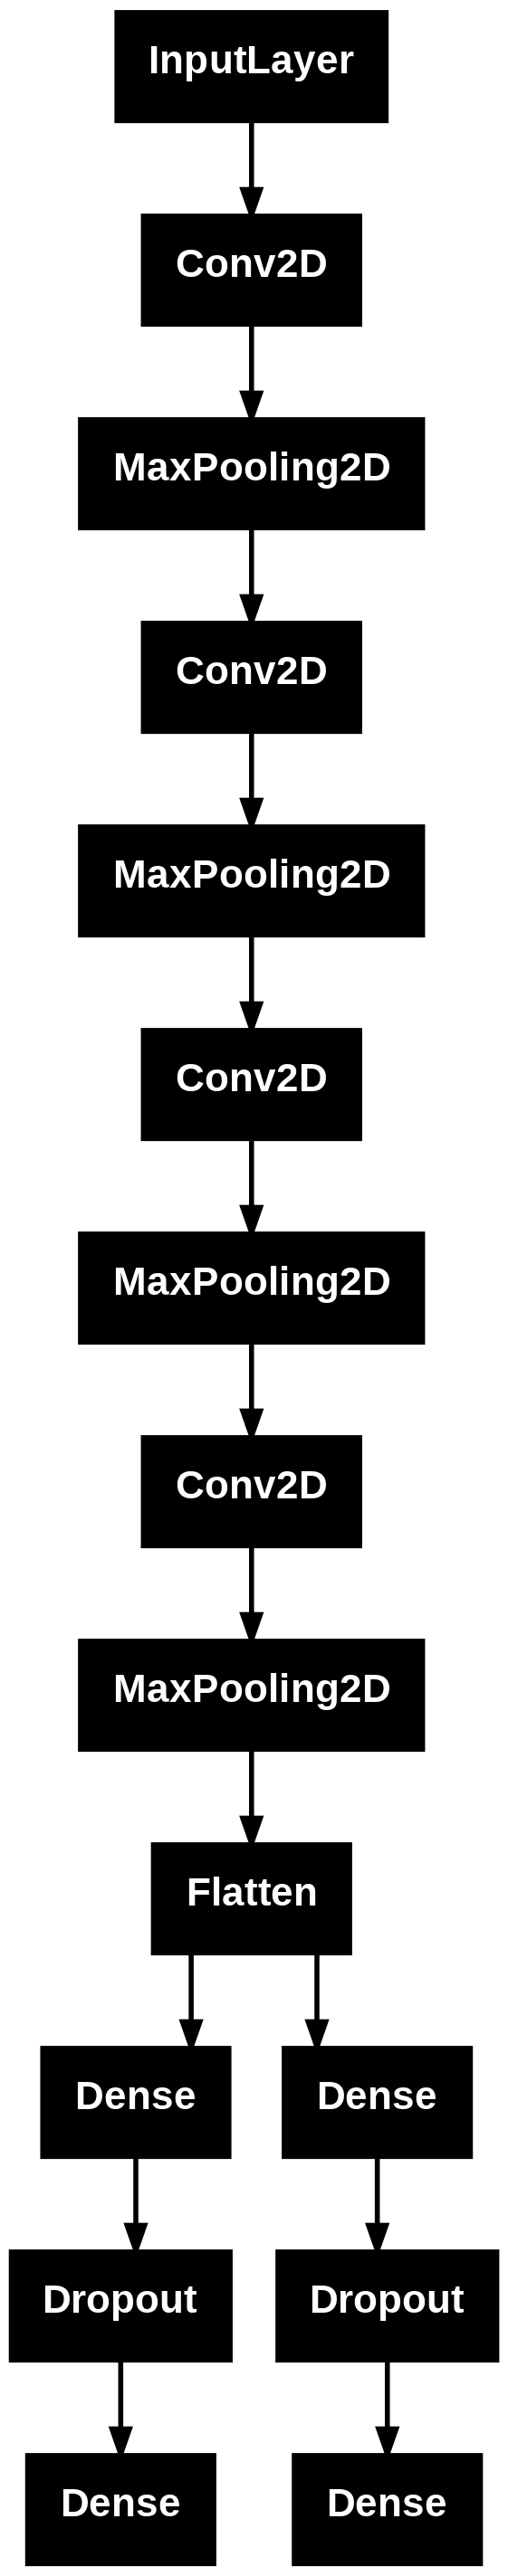

In [52]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [53]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - age_out_accuracy: 0.0833 - age_out_loss: 4.2866 - gender_out_accuracy: 0.6826 - gender_out_loss: 0.6426 - loss: 4.9293 - val_age_out_accuracy: 0.0998 - val_age_out_loss: 3.9609 - val_gender_out_accuracy: 0.6805 - val_gender_out_loss: 0.6331 - val_loss: 4.5911
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - age_out_accuracy: 0.1023 - age_out_loss: 3.9255 - gender_out_accuracy: 0.7051 - gender_out_loss: 0.6085 - loss: 4.5340 - val_age_out_accuracy: 0.1014 - val_age_out_loss: 3.8883 - val_gender_out_accuracy: 0.6928 - val_gender_out_loss: 0.5909 - val_loss: 4.4748
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - age_out_accuracy: 0.1033 - age_out_loss: 3.8593 - gender_out_accuracy: 0.7045 - gender_out_loss: 0.5720 - loss: 4.4312 - val_age_out_accuracy: 0.0998 - val_age_out_loss: 3.8857 - val_gender_out_accuracy: 0.6943 - val_gender_out_loss: 0.5802 - val_loss: 4.4560
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - age_out_

Plot the Results

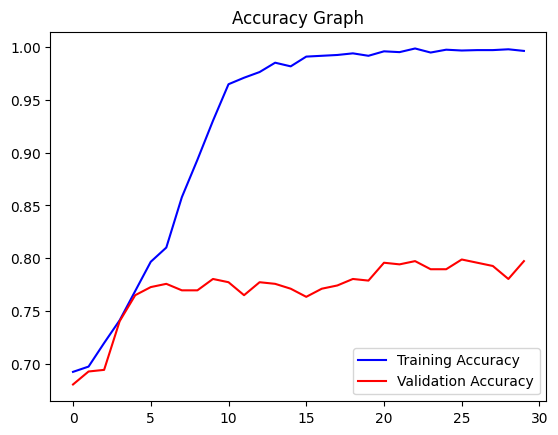

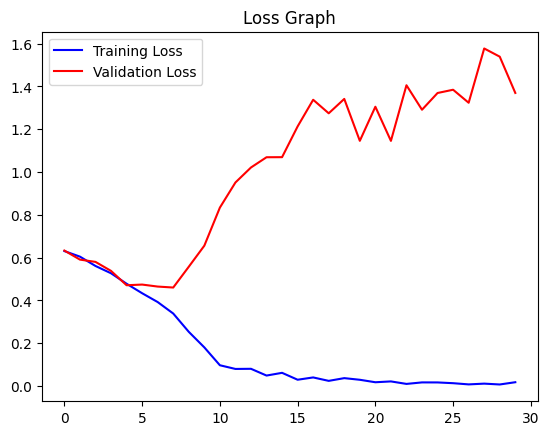

In [54]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

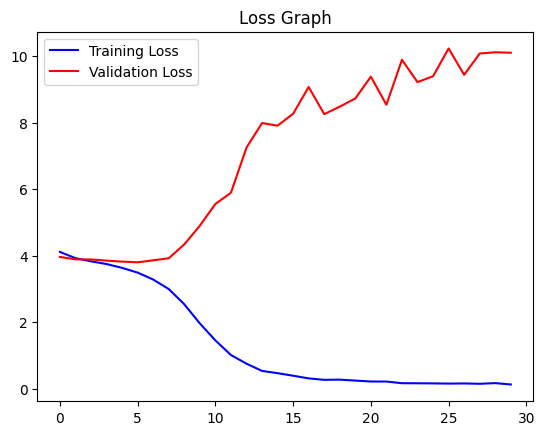

In [55]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Predicted Gender: Male Predicted Age: 62


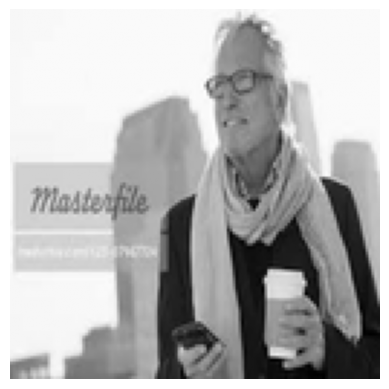

In [59]:
image_index = 10
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = np.argmax(pred[1][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Gender: Male Predicted Age: 45


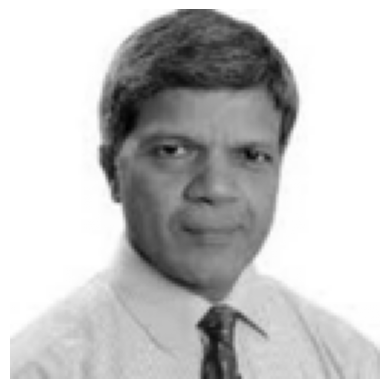

In [58]:
image_index = 300
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = np.argmax(pred[1][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted Gender: Female Predicted Age: 61


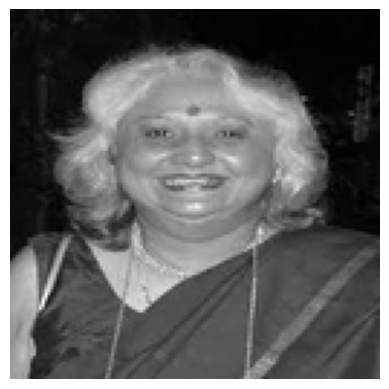

In [61]:
image_index = 2500
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = np.argmax(pred[1][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Gender: Male Predicted Age: 47


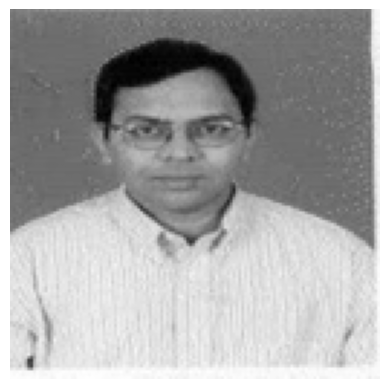

In [62]:
image_index = 2567
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = np.argmax(pred[1][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted Gender: Male Predicted Age: 45


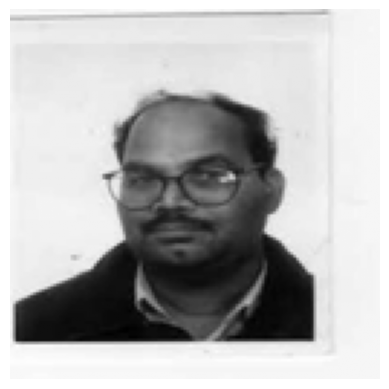

In [63]:
image_index = 1577
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = np.argmax(pred[1][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');